# Get Data From Drive

In [ ]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t
To: /content/Dataset.zip
100% 845M/845M [00:10<00:00, 80.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t
To: /content/Patterns.zip
100% 271M/271M [00:03<00:00, 89.2MB/s]


In [ ]:
!unzip /content/Dataset.zip -d Dataset
!unzip /content/Patterns.zip -d Patterns

Archive:  /content/Dataset.zip
 extracting: Dataset/1644359422.816138.jpg  
  inflating: Dataset/1644359422.816138.json  
 extracting: Dataset/1644360063.82364.jpg  
  inflating: Dataset/1644360063.82364.json  
 extracting: Dataset/1644362482.7094185.jpg  
  inflating: Dataset/1644362482.7094185.json  
 extracting: Dataset/1644368971.6154966.jpg  
  inflating: Dataset/1644368971.6154966.json  
 extracting: Dataset/1644369207.922902.jpg  
  inflating: Dataset/1644369207.922902.json  
 extracting: Dataset/1644369658.7214494.jpg  
  inflating: Dataset/1644369658.7214494.json  
 extracting: Dataset/1644369774.9055796.jpg  
  inflating: Dataset/1644369774.9055796.json  
 extracting: Dataset/1644369801.9909956.jpg  
  inflating: Dataset/1644369801.9909956.json  
 extracting: Dataset/1644369842.0238864.jpg  
  inflating: Dataset/1644369842.0238864.json  
 extracting: Dataset/1644369905.2248352.jpg  
  inflating: Dataset/1644369905.2248352.json  
 extracting: Dataset/1644369972.1056488.jpg  
 

# Read image and pattern

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import json

In [ ]:
img_name = "/content/Dataset/1644362482.7094185.jpg"
json_name = img_name[:-3] + "json"

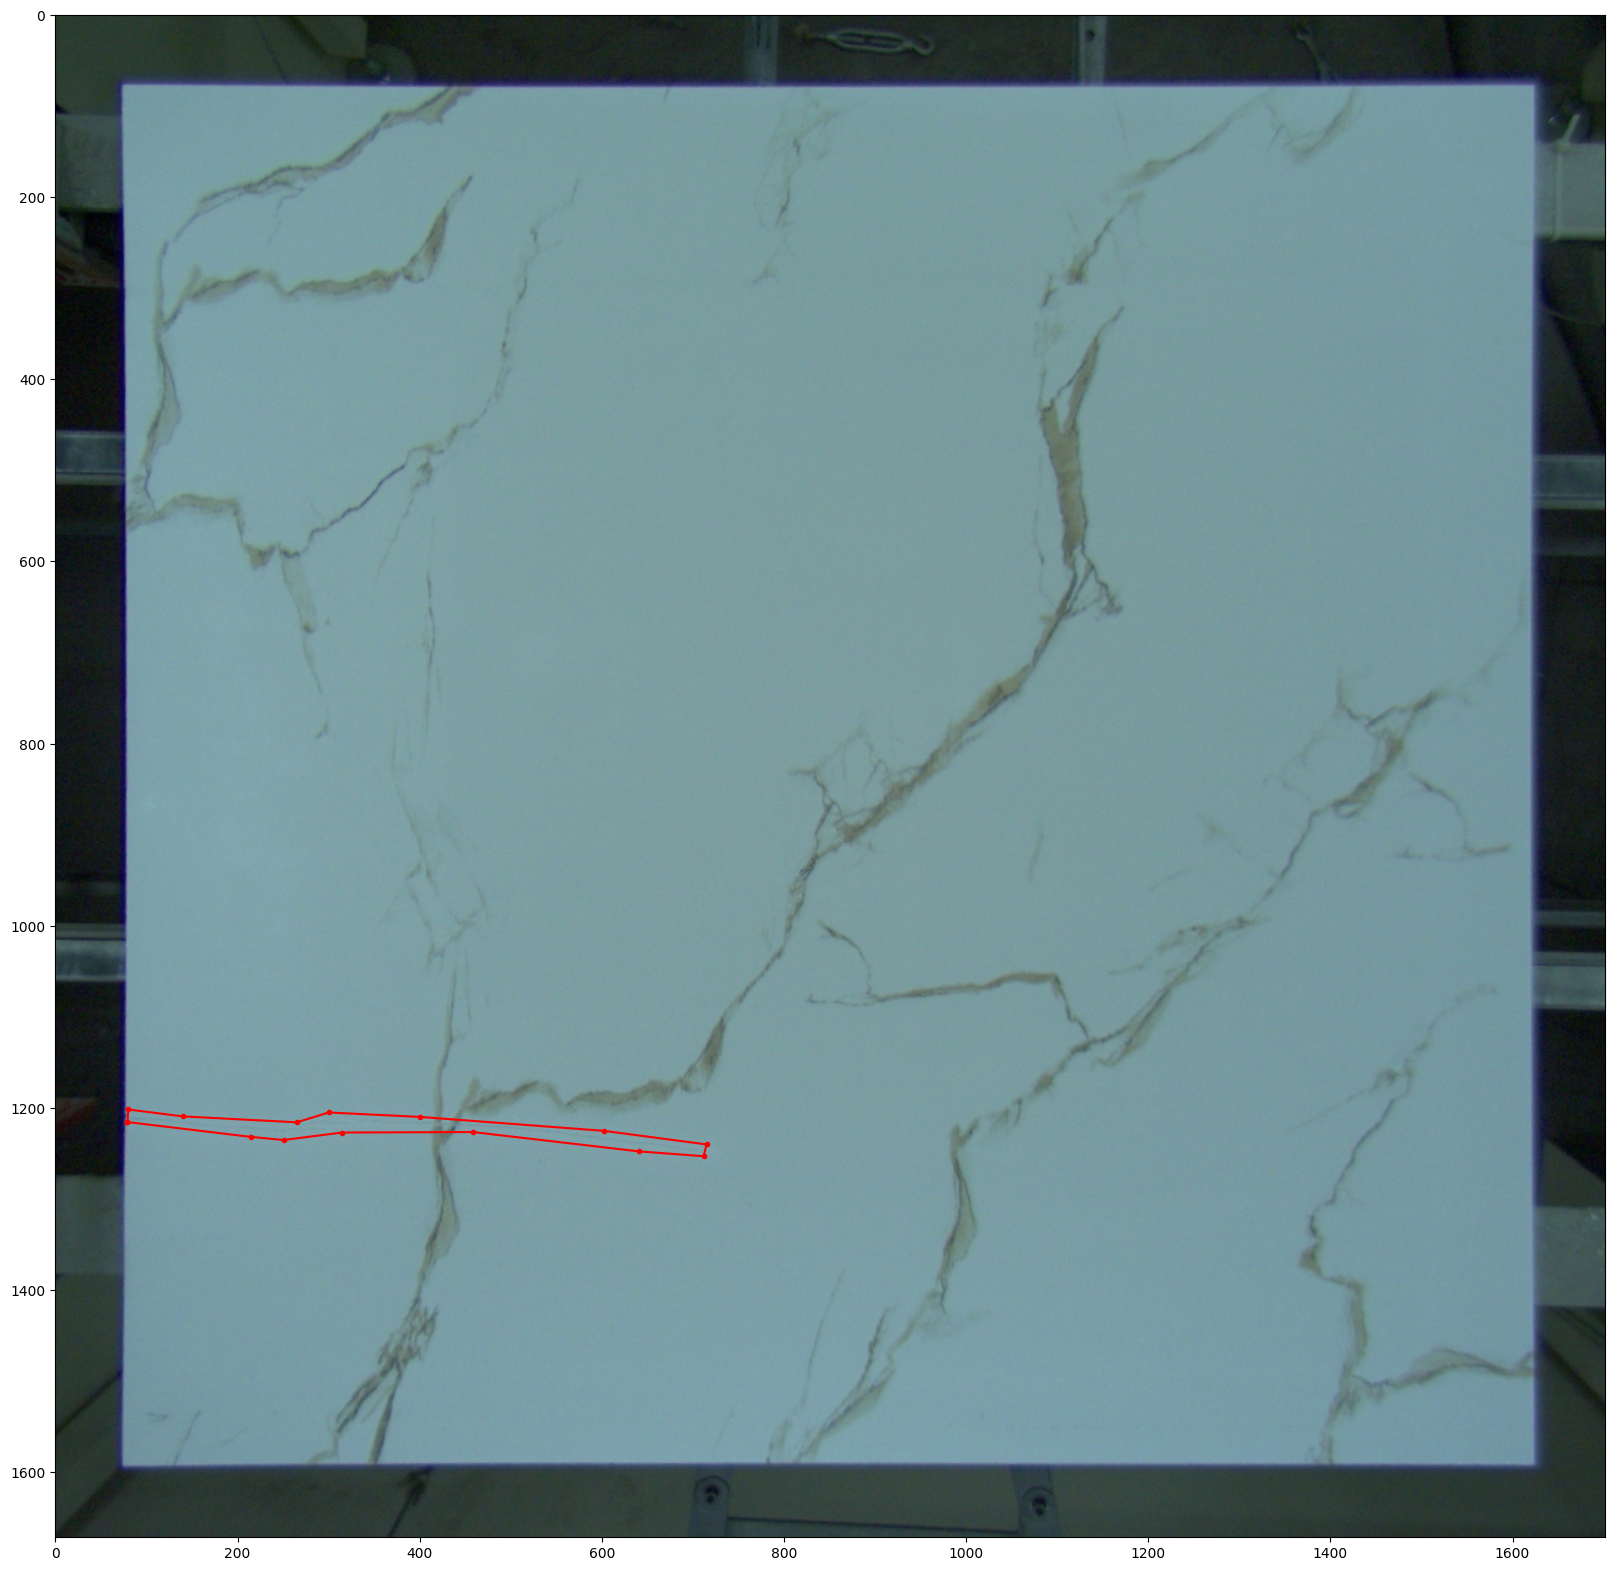

In [ ]:
img = cv.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
f.close()

plt.figure(figsize=(20, 20))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]: # array of json include taraks
  # shape :
  # {
  #           "label": "tarak",
  #           "points": [
  #               [
  #                   1239.6180419921875,
  #                   768.5914306640625
  #               ],
  #               [
  #                   1298.614990234375,
  #                   758.45849609375
  #               ],
  #               [
  #                   1300.58203125,
  #                   769.4680786132812
  #               ],
  #               [
  #                   1233.1680908203125,
  #                   777.0652465820312
  #               ]
  #           ],
  #           "group_id": null,
  #           "shape_type": "polygon",
  #           "flags": {}
  #       }
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

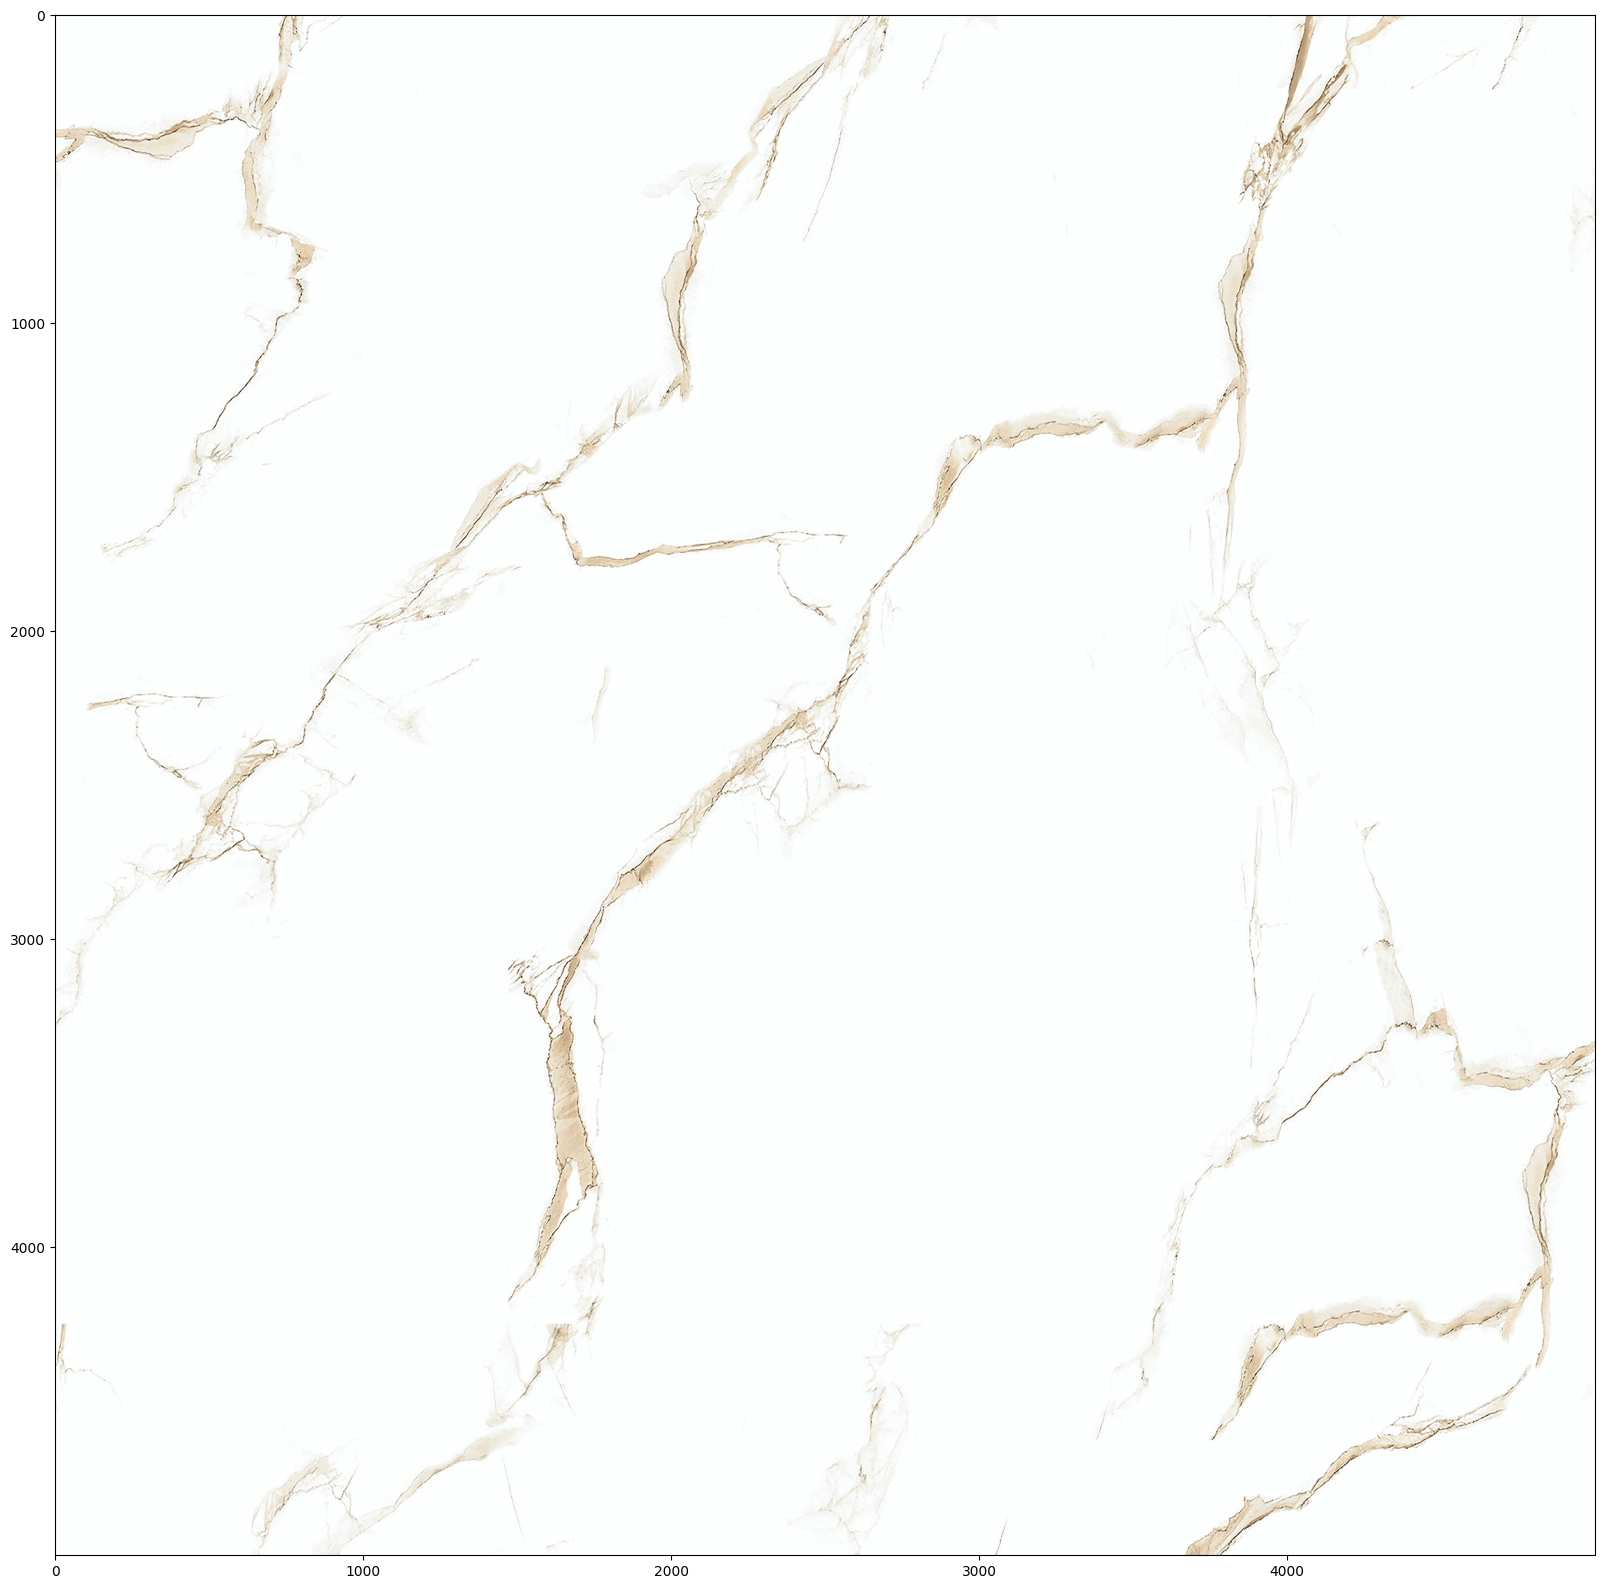

In [ ]:
pattern = cv.imread('/content/Patterns/' + data['pattern']) # e.g. "AYLIN.tif"

plt.figure(figsize=(20, 20))
plt.imshow(pattern[..., ::-1])

# Prepare Sequence class to load & vectorize batches of data

In [ ]:
def create_target(input_img_path):
  img = cv.imread(input_img_path)
  input_json_path = input_img_path[:-3] + 'json'
  f = open(input_json_path, encoding="utf8")
  data = json.load(f)
  f.close()

  shapes = data["shapes"]
  for shape in shapes:
    if shape["label"] == "tarak":
      points = np.array(shape["points"]) # taraks
      cv.fillPoly(img, pts=np.int32([points]), color=(0, 0, 255)) # Draw a filled polygon

  indices = np.where(img != (0, 0, 255))
  img[indices] = 0

  indices = np.where(img == (0, 0, 255))
  img[indices] = 128

  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  i1 = np.where(gray == gray[0, 0])
  i2 = np.where(gray != gray[0, 0])
  gray[i1] = 0 # not taraks
  gray[i2] = 128 # taraks

  return gray.copy()

In [ ]:
def get_corresponding_pattern(input_img_path):
  input_json_path = input_img_path[:-3] + 'json'
  f = open(input_json_path, encoding="utf8")
  data = json.load(f)
  f.close()
  pattern = cv.imread('/content/Patterns/' + data['pattern'])

  return pattern.copy()

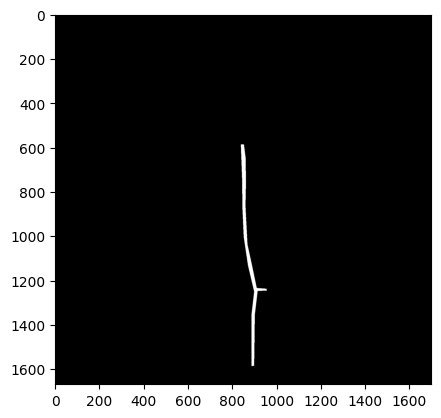

In [ ]:
img_path = '/content/Dataset/1644360063.82364.jpg'
target = create_target(img_path)
plt.imshow(target, cmap="gray")

**Perprocessing**

In [ ]:
def find_rotation_degree(good_points, kp_1, kp_2):
  # kp_1[i].pt -> mokhtasat in tile image
  # kp_2[i].pt -> mokhtasat in pattern
  # good_points[i].queryIdx -> keypoint in tile
  # good_points[i].trainIdx -> keypoint in pattern

  degrees = {'0' : 0, '90': 0, '180' : 0, '270' : 0} # all degrees can be rotated
  for good_point in good_points:
    key1_index = good_point.queryIdx
    key2_index = good_point.trainIdx

    x_1, y_1 = kp_1[key1_index].pt # 0 to 1600
    x_2, y_2 = kp_2[key2_index].pt # 0 to 5000
    # print(f"({x_1}, {y_1}) -> ({x_2}, {y_2})")

    # 800,2500 ?
    # ==============================
    if x_1 < 800 and y_1 < 800: # left top
      if x_2 < 800 and y_2 < 800:
        degrees['0'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['90'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['180'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['270'] += 1
    # ==============================
    elif x_1 < 800 and y_1 > 800: # left bottom
      if x_2 < 800 and y_2 < 800:
        degrees['270'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['0'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['90'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['180'] += 1
    # ===============================
    elif x_1 > 800 and y_1 > 800: # right top
      if x_2 < 800 and y_2 < 800:
        degrees['180'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['270'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['0'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['90'] += 1
    # ==============================
    elif x_1 > 800 and y_1 < 800: # right bottom
      if x_2 < 800 and y_2 < 800:
        degrees['90'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['180'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['270'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['0'] += 1
  result = None
  # print(degrees)
  m = 0
  for k in degrees.keys(): # finding the most repeated degree
    if degrees[k] > m:
      m = degrees[k]
      result = k
  return result

# https://pysource.com/2018/07/20/find-similarities-between-two-images-with-opencv-and-python/
def find_keypoints(img1, img2):
  original = img1 # queryImage
  image_to_compare = img2 # trainImage
  height, width, c = original.shape

  sift = cv.xfeatures2d.SIFT_create()
  kp_1, desc_1 = sift.detectAndCompute(original, None)
  kp_2, desc_2 = sift.detectAndCompute(image_to_compare, None)

  index_params = dict(algorithm=0, trees=5)
  search_params = dict()
  flann = cv.FlannBasedMatcher(index_params, search_params)

  matches = flann.knnMatch(desc_1, desc_2, k=2)

  good_points = []
  ratio = 0.7
  for m, n in matches:
      if m.distance < ratio*n.distance:
          good_points.append(m)

  no_of_matches = len(good_points)
  # result = cv.drawMatches(original, kp_1, image_to_compare, kp_2, good_points, None)

  deg = find_rotation_degree(good_points, kp_1, kp_2)
  return deg

def rotate_image(img, deg):
  if deg == '90':
    return cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

  elif deg == '180':
    return cv.rotate(img, cv.ROTATE_180)

  elif deg == '270':
    return cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)

  else: # deg == '0'
    return img

def subtract_with_morpholgy(image, pattern):
  gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY )
  binary_image = cv.adaptiveThreshold(gray_image,100,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,21,5)
  # convert to binary image (background is white, foreground is black)

  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))
  kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))


  gray_pattern = cv.cvtColor(pattern, cv.COLOR_BGR2GRAY )
  binary_pattern = cv.adaptiveThreshold(gray_pattern,100,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,21,5)

  # growing the pattern
  eroded = cv.erode(gray_pattern,kernel,iterations=5)
  eroded_2 = cv.erode(eroded,kernel2,iterations=3)
  dilated = cv.dilate(eroded_2,kernel)
  opened = cv.morphologyEx(dilated, cv.MORPH_OPEN, kernel2,iterations=2) # removing the white pixels inside the pattern(black pixels)

  res = cv.subtract(opened, binary_image) # https://www.geeksforgeeks.org/how-to-subtract-two-images-using-python-opencv/ # https://docs.opencv.org/3.4/dd/d4d/tutorial_js_image_arithmetics.html
  # res = cv.resize(temp, dsize=(0,0), fx=224/1516, fy=224/1516)

  res = cv.cvtColor(res, cv.COLOR_GRAY2BGR)

  return res


In [ ]:
img_name = "/content/Dataset/1644362482.7094185.jpg"
img = cv.imread(img_name)
json_name = img_name[:-3] + "json"
f = open(json_name, encoding="utf8")
data = json.load(f)
f.close()
pattern = cv.imread('/content/Patterns/' + data['pattern'])
# find_keypoints(img, pattern)
find_keypoints(img, cv.resize(pattern, (1600, 1600), interpolation=cv.INTER_AREA))


'180'

In [ ]:
from skimage.exposure import match_histograms

def subtract_pattern_from_image(img, pattern):
    """
        preprocessing and subtracting patten from image
    """

    # histogram matching on pattern
    # change the pattern to match the histogram of the image
    reference = img
    source = pattern
    matched_pattern = match_histograms(source, reference, multichannel=True)

    # removing rotation
    rotate_degree = find_keypoints(img, matched_pattern)
    rotated_matched_pattern = rotate_image(matched_pattern, rotate_degree) # also can use original pattern size 5000*5000 taher than resied 1600*1600

    # subtracting pattern from image
    subtracted_image = subtract_with_morpholgy(img, rotated_matched_pattern)

    return subtracted_image


In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os

class Tiles(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8") # (100, 1600, 1600, 3)
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8") # (100, 1600, 1600, 1)
        pad = 70
        for j, path in enumerate(batch_input_img_paths):
            # input img
            img = load_img(path)
            img = np.array(img)
            img = img[pad:-pad, pad:-pad] # crop the paddings
            img = cv.resize(img, self.img_size, interpolation=cv.INTER_AREA) # resize
            # x[j] = img # before adding preprocess

            # pattern img
            pattern = get_corresponding_pattern(path)
            pattern = np.array(pattern)
            pattern = cv.resize(pattern, self.img_size, interpolation=cv.INTER_AREA)

            # subtracting pattern from image
            x[j] = subtract_pattern_from_image(img, pattern) # before adding preprocess

            # target img
            target_img = create_target(path) # our defined function
            target_img = target_img[pad:-pad, pad:-pad].copy()
            target_img = cv.resize(target_img, self.img_size, interpolation=cv.INTER_AREA)
            indices = np.where(target_img != 0)
            target_img[indices] = 1 # tarak (127 -> 1)
            y[j] = np.expand_dims(target_img, 2) # Expand the shape of an array. 1 -> [1] [ (1600,1600, ) -> (1600,1600,1) ]

        return x, y

# Prepare U-Net Xception-style model

In [ ]:
# https://www.kaggle.com/code/meaninglesslives/unet-xception-keras-for-pneumothorax-segmentation/notebook
# https://www.researchgate.net/figure/U-Net-architecture-X-ception-style_fig4_364690133
# https://github.com/cnzakimuena/U-Net
# https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
num_classes = 2 # tarak, not tarak
batch_size = 2
img_size = (1600, 1600)

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) # (1600, 1600, 3)

    ### [First half of the network: downsampling inputs] ###
    ## encoding
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    ## ?? using skip connections?

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x) # https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D
        # Separable convolutions consist of first performing a depthwise spatial convolution (which acts on each input channel separately) followed by a pointwise convolution which mixes the resulting output channels. The depth_multiplier argument controls how many output channels are generated per input channel in the depthwise step.
            # Intuitively, separable convolutions can be understood as a way to factorize a convolution kernel into two smaller kernels, or as an extreme version of an Inception block.
        x = layers.BatchNormalization()(x) # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
        # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
            # Importantly, batch normalization works differently during training and during inference.

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###
    # decoding
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x) # Transposed convolution layer (sometimes called Deconvolution).
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose
        # The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x) # https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    if num_classes == 2: # tarak or not tarak
      outputs = layers.Conv2D(1, 3, padding="same")(x) # (batch_size, img1, img2, num_class)
    else:
      raise Exception("Define a custom last layer.")

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1600, 1600,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 800, 800, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 800, 800, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

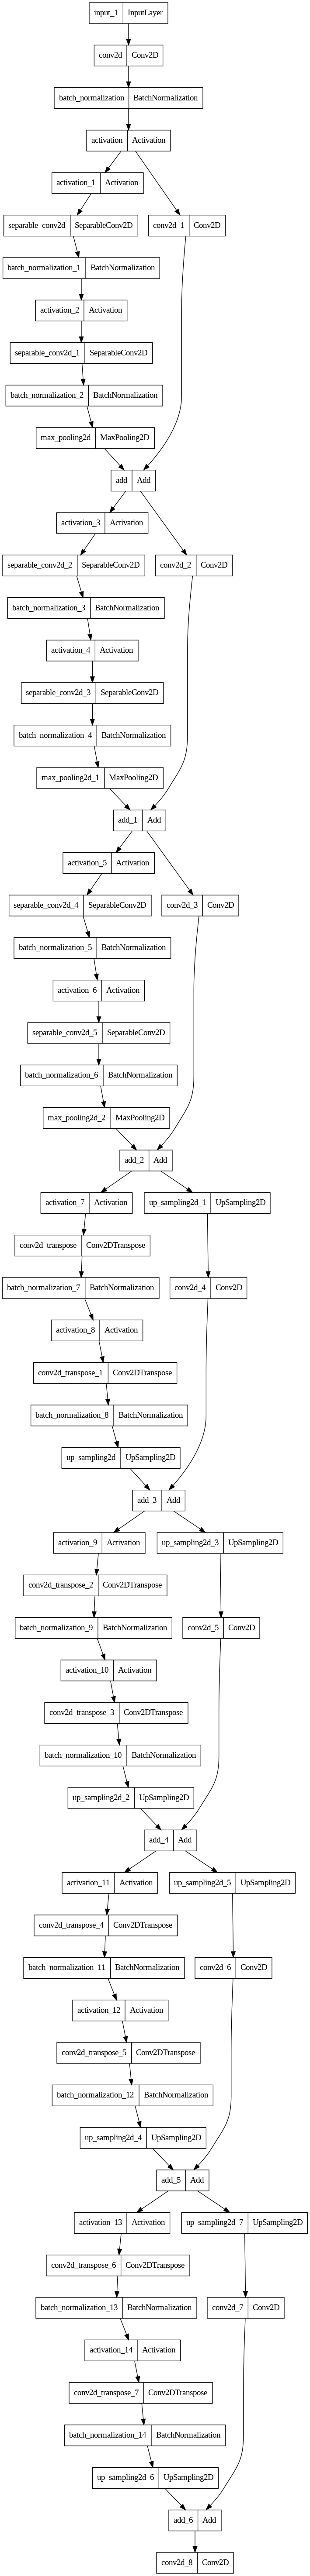

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()
keras.utils.plot_model(model)

# Read Prepared And Augmented Data Again

In [ ]:
import os

input_dir = "/content/Dataset"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if not fname.endswith(".json")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path in input_img_paths[-15:]:
    print(input_path, "|", input_path[:-3] + 'json')

Number of samples: 308
/content/Dataset/1644880490.5008993.bmp | /content/Dataset/1644880490.5008993.json
/content/Dataset/1644888240.3566377.bmp | /content/Dataset/1644888240.3566377.json
/content/Dataset/1644888256.0602736.bmp | /content/Dataset/1644888256.0602736.json
/content/Dataset/1645634834.280746.png | /content/Dataset/1645634834.280746.json
/content/Dataset/1645635002.2771971.png | /content/Dataset/1645635002.2771971.json
/content/Dataset/1645635060.518038.png | /content/Dataset/1645635060.518038.json
/content/Dataset/1645635105.105883.png | /content/Dataset/1645635105.105883.json
/content/Dataset/1645635195.07319.png | /content/Dataset/1645635195.07319.json
/content/Dataset/1645635304.7972324.png | /content/Dataset/1645635304.7972324.json
/content/Dataset/1645635403.8522236.png | /content/Dataset/1645635403.8522236.json
/content/Dataset/1645635488.3734396.png | /content/Dataset/1645635488.3734396.json
/content/Dataset/1645635557.7693658.png | /content/Dataset/1645635557.7693

# Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 50
train_input_img_paths = input_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
# random.Random(0).shuffle(train_input_img_paths)
# random.Random(0).shuffle(val_input_img_paths)

# Instantiate data Sequences for each split
train_gen = Tiles(batch_size, img_size, train_input_img_paths) #  """Helper to iterate over the data (as Numpy arrays)."""
val_gen = Tiles(batch_size, img_size, val_input_img_paths) #  """Helper to iterate over the data (as Numpy arrays)."""

## See Tile & Pattern & Mask

<ipython-input-12-21393ecff8f9>:12: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched_pattern = match_histograms(source, reference, multichannel=True)


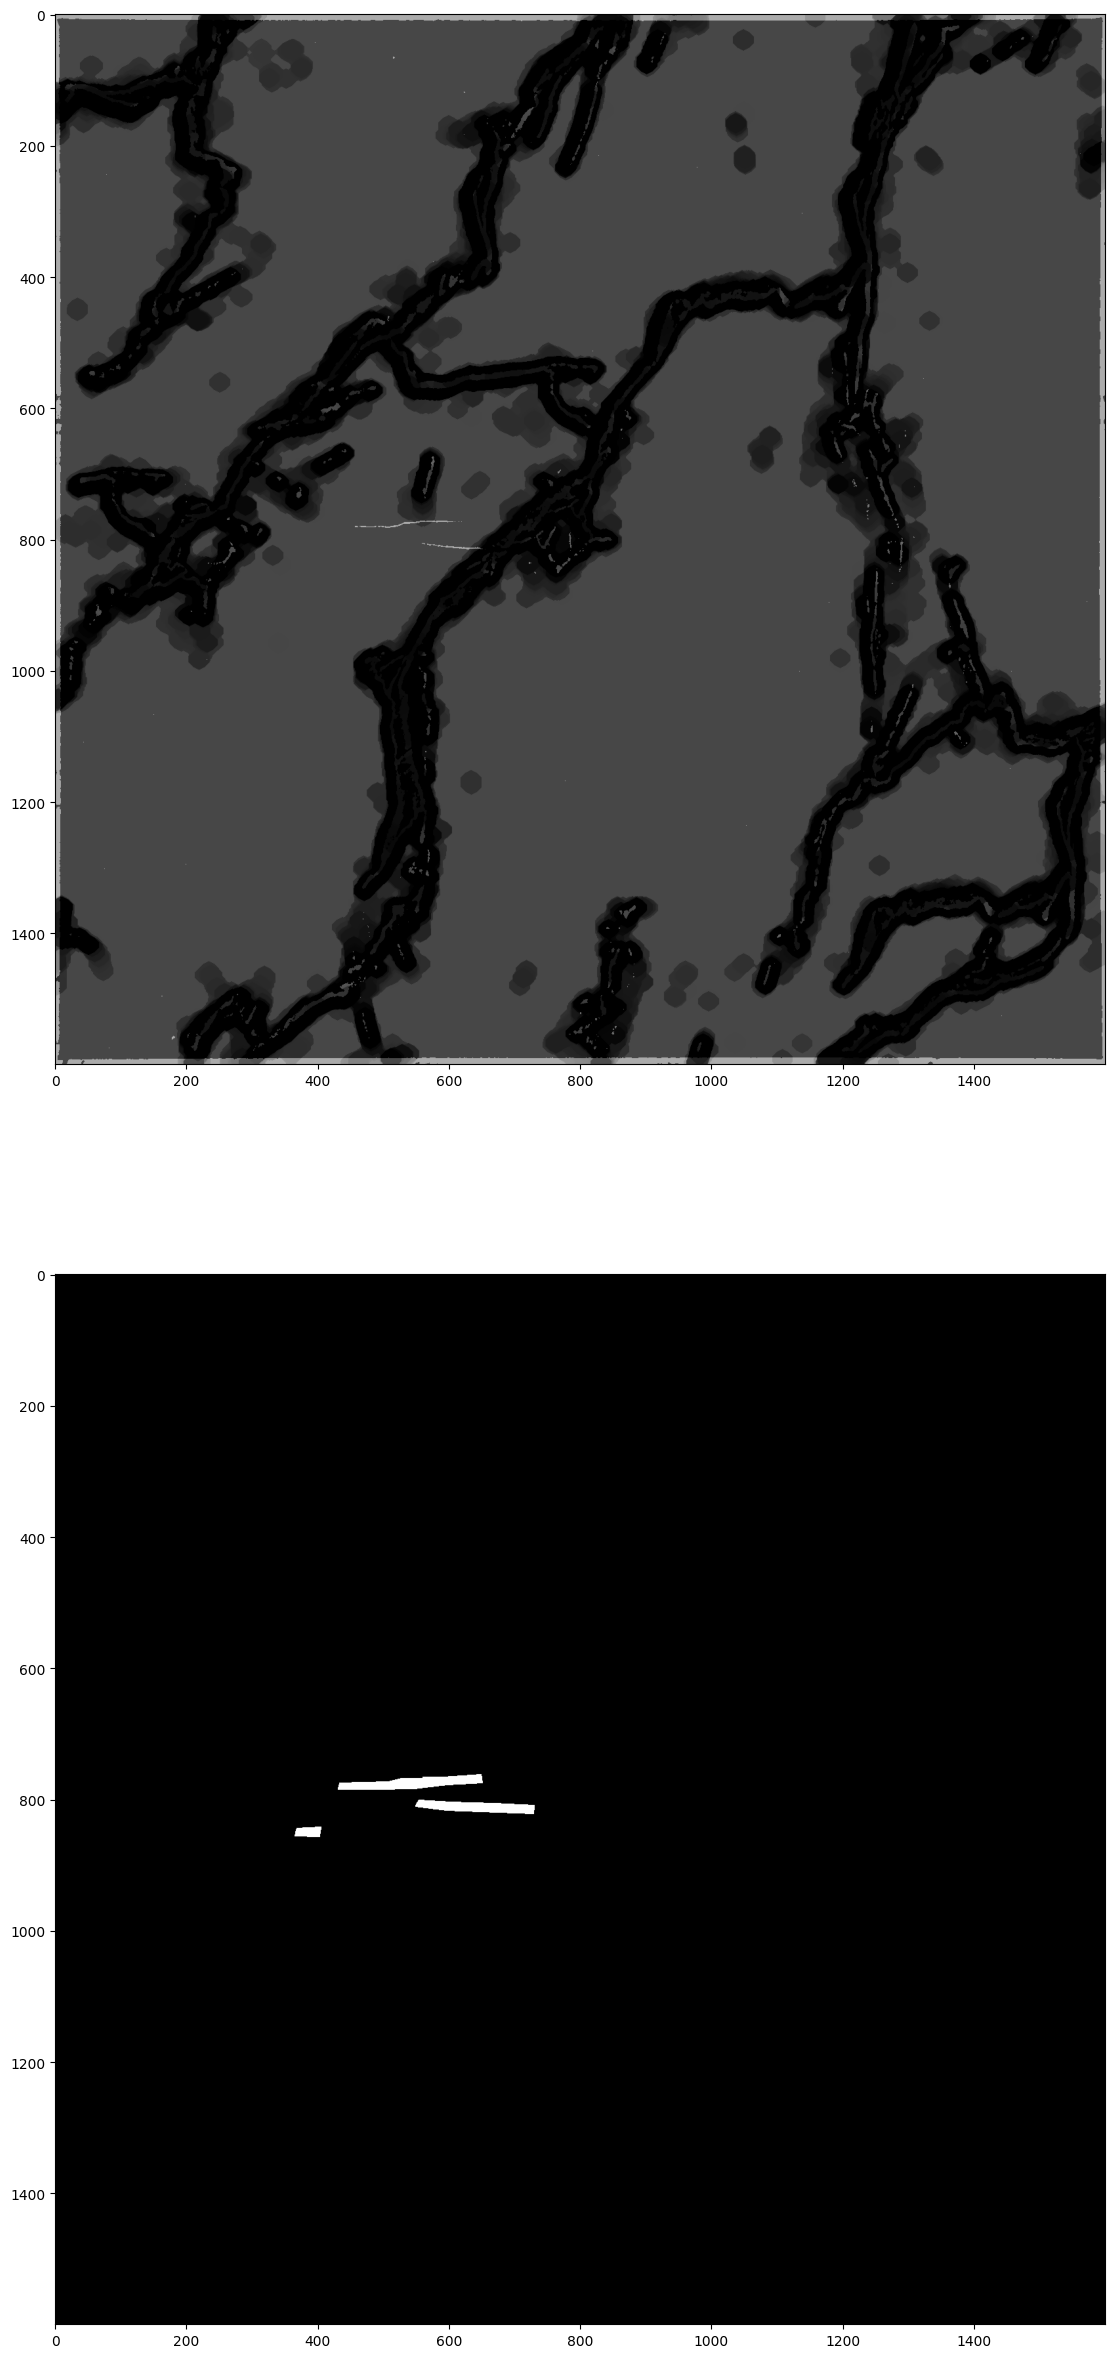

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplot(2, 1, 1)
imgs, targets = train_gen[7]
plt.imshow(imgs[0]) # imgs[1]

plt.subplot(2, 1, 2)
plt.imshow(targets[0], cmap="gray") # targets[1]

In [ ]:
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)

In [ ]:
import tensorflow as tf
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=0.01):
  # ref: https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html#6
  # (batch_size, img1, img2, num_class)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred) # DC ≥ IoU

  return (numerator + smooth) / (denominator + smooth)

def dice_bce_loss(y_true, y_pred):
    """combine DICE and BCE"""
    # ref: https://www.kaggle.com/code/kmader/u-net-with-dice-and-augmentation/notebook
    dice_loss =  1 - dice_coef(y_true, y_pred)
    return 0.01 * binary_crossentropy(y_true, y_pred) + dice_loss

# Train the model

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# save best weights
# ref: https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_bce_loss, metrics=[dice_coef])

epochs = 10
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[checkpoint])

<ipython-input-12-21393ecff8f9>:12: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched_pattern = match_histograms(source, reference, multichannel=True)


Epoch 1/10
129/129 [==============================] - ETA: 0s - loss: 0.7705 - dice_coef: 0.2337
Epoch 1: val_loss improved from inf to 1.00011, saving model to my_best_model.epoch01-loss1.00.hdf5
129/129 [==============================] - 1049s 8s/step - loss: 0.7705 - dice_coef: 0.2337 - val_loss: 1.0001 - val_dice_coef: 1.1408e-04
Epoch 2/10
129/129 [==============================] - ETA: 0s - loss: 0.6525 - dice_coef: 0.3477
Epoch 2: val_loss did not improve from 1.00011
129/129 [==============================] - 1009s 8s/step - loss: 0.6525 - dice_coef: 0.3477 - val_loss: 1.0002 - val_dice_coef: 4.2414e-05
Epoch 3/10
129/129 [==============================] - ETA: 0s - loss: 0.6261 - dice_coef: 0.3740
Epoch 3: val_loss improved from 1.00011 to 0.72573, saving model to my_best_model.epoch03-loss0.73.hdf5
129/129 [==============================] - 997s 8s/step - loss: 0.6261 - dice_coef: 0.3740 - val_loss: 0.7257 - val_dice_coef: 0.2745
Epoch 4/10
129/129 [==========================

In [ ]:
# save latest weights
model.save_weights('unet.h5')

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('dice_bce_loss')
plt.savefig('model_training_history')
plt.show()

# Visualize predictions


In [ ]:
# load best weights
keras.backend.clear_session()
filepath = "my_best_model.epoch05-loss0.72.hdf5"
model = keras.models.load_model(filepath, custom_objects={"dice_bce_loss": dice_bce_loss, "dice_coef": dice_coef})

In [ ]:
from PIL import ImageOps

# Generate predictions for all images in the validation set
val_gen = Tiles(batch_size, img_size, val_input_img_paths) # 50 images (25 batches)
val_preds = model.predict(val_gen)

In [ ]:
from IPython.display import Image, display

def get_visualization(i, img):
    """Quick utility to display a model's prediction."""
    probability = 1e-20
    predict = img.copy()
    mask = val_preds[i]
    mask = tf.math.sigmoid(mask)
    mask = np.array(mask)

    indices = np.where(mask >= probability)
    mask[indices] = 128

    indices = indices[0], indices[1]
    predict[indices] = (255, 0, 0)

    return mask, predict

# Display results for validation image #i
i = 0
batch = i // batch_size
j = i % batch_size
imgs, targets = val_gen[batch]

# Display input image
plt.figure(figsize=(30, 30))
plt.subplot(4, 1, 1)
plt.imshow(imgs[j])

# Display ground-truth target mask
plt.subplot(4, 1, 2)
plt.imshow(targets[j], cmap="gray")

# Display mask predicted by our model
plt.subplot(4, 1, 3)
mask, prediction = get_visualization(i, imgs[j])
plt.imshow(mask, cmap="gray")

plt.subplot(4, 1, 4)
plt.imshow(prediction)

In [ ]:
# define predict function
# define predict function
def my_get_visualization(img, mask):
    """Quick utility to display a model's prediction."""
    probability = 1e-20
    predict = img.copy()
    mask = tf.math.sigmoid(mask)
    mask = np.array(mask)

    indices = np.where(mask >= probability)
    mask[indices] = 128

    indices = indices[0], indices[1]
    predict[indices] = (255, 0, 0)

    return mask, predict


def predict_func(image, pattern):
    '''
    Receive the corresponding image and design and return the coordinates of the cracks inside it
    '''

    # load best weights
    keras.backend.clear_session()
    filepath = "my_best_model.epoch06-loss0.25.hdf5"
    model = keras.models.load_model(filepath, custom_objects={"dice_bce_loss": dice_bce_loss, "dice_coef": dice_coef})

    # load image
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (1600, 1600))
    img = np.array(img)
    img = img / 255.0
    img = img.astype(np.float32)

    # load pattern
    pattern = cv.imread(pattern)
    pattern = cv.cvtColor(pattern, cv.COLOR_BGR2RGB)
    pattern = cv.resize(pattern, (1600, 1600))
    pattern = np.array(pattern)
    pattern = pattern / 255.0
    pattern = pattern.astype(np.float32)

    img = subtract_pattern_from_image(img, pattern)

    # predict

    # print(img.shape) # (1600, 1600, 6)
    # mask = model.predict([img.copy(), img.copy()])

    img = np.expand_dims(img, axis=0)
    # print(img.shape) # (1, 1600, 1600, 6)

    mask = model.predict(img)
    # method 1
    # mask, prediction = my_get_visualization(img[0, :, :, :], mask[0, :, :, :])
    # mask = np.where(mask >= 0.5, 1, 0)
    # mask = mask.astype(np.uint8)

    # method 2
    mask = tf.math.sigmoid(mask)
    mask = np.array(mask)
    mask = mask[0, :, :, 0]
    mask = np.where(mask >= 0.5, 1, 0)
    mask = mask.astype(np.uint8)

    # get coordinates
    contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for i in range(len(contours)):
        x, y, w, h = cv.boundingRect(contours[i])
        coordinates.append([x, y, x+w, y+h])

    return coordinates

